In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas_ta as ta

import technical_analysis.backtest_kz as bt
from data_pipelines.data_manipulation import DataManipulation
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action = 'ignore', category = pd.errors.PerformanceWarning)
%matplotlib inline

In [3]:
def cvd(full_df: pd.DataFrame()):
    month_groups = full_df.groupby(pd.Grouper(freq='M'))

    monthly_deltas = []

    for _, group in month_groups:
        df = group.copy()

        df['open_close_max'] = df.high - df[["open", "close"]].max(axis=1)
        df['open_close_min'] = df[["open", "close"]].min(axis=1) - df.low
        df['open_close_abs'] = (df.close - df.open).abs()
        df['is_close_larger'] = df.close >= df.open
        df['is_open_larger'] = df.open > df.close
        df['is_body_cond_met'] = df.is_close_larger | df.is_open_larger
    
        df.loc[df.is_body_cond_met == False, 'open_close_abs_2x'] = 0
        df.loc[df.is_body_cond_met == True, 'open_close_abs_2x'] = 2*df.open_close_abs

        df['nominator'] = df.open_close_max + df.open_close_min + df.open_close_abs_2x
        df['denom'] = df.open_close_max + df.open_close_min + df.open_close_abs
        
        df['delta'] = 0
        df.loc[df.denom == 0, 'delta'] = 0.5
        df.loc[df.denom != 0, 'delta'] = df.nominator / df.denom
        df.loc[df.is_close_larger == False, 'delta'] = df.loc[df.is_close_larger == False, 'volume'] * (-df.loc[df.is_close_larger == False, 'delta'])
        df.loc[df.is_close_larger == True, 'delta'] = df.loc[df.is_close_larger == True, 'volume'] * (df.loc[df.is_close_larger == True, 'delta'])

        monthly_deltas.append(pd.Series(np.cumsum(df.delta.values)))
    
    all_deltas = pd.concat(monthly_deltas).reset_index(drop=True)
    full_df = full_df.reset_index()
    full_df['cvd'] = all_deltas
    full_df = full_df.set_index('Datetime')
    return full_df

In [4]:
SYMBOL = ''
scale = 1
range_list = [5, 9,10,12, 15, 20, 26, 50, 200]
range_list = [i*scale for i in range_list]
period = 'max'
interval = '1d'
start_date = ''
end_data = ''
source = 'yahoo'

In [5]:
SYMBOL = 'ARCLK.IS'
data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=False)

[*********************100%***********************]  1 of 1 completed
Get ARCLK.IS data from yahoo period: max and interval: 1d
Start TA-LIB module
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values


In [6]:
df_arcelik = data.df.loc['2022-05-01':, :].copy()
for i in range(1,4):
    df_arcelik[f'pct_{i}'] = -1 * df_arcelik.close.pct_change(-i).round(3)
df_arcelik['ema12_cross_ema50'] = (df_arcelik.ema_12 > df_arcelik.ema_50).astype(int)
df_arcelik['ema5_cross_ema10'] = (df_arcelik.ema_5 > df_arcelik.ema_10).astype(int)
df_arcelik['ema5_cross_ema20'] = (df_arcelik.ema_5 > df_arcelik.ema_20).astype(int)
df_arcelik['ema9_cross_ema26'] = (df_arcelik.ema_9 > df_arcelik.ema_26).astype(int)
df_arcelik['ema20_cross_ema50'] = (df_arcelik.ema_20 > df_arcelik.ema_50).astype(int)
df_arcelik['ema50_cross_ema200'] = (df_arcelik.ema_50 > df_arcelik.ema_200).astype(int)
df_arcelik['ema12_cross_ema26'] = (df_arcelik.ema_12 > df_arcelik.ema_26).astype(int)

df_result = df_arcelik[['close', 'volume', 'ema5_cross_ema10', 'ema5_cross_ema20', 'ema9_cross_ema26', 'ema20_cross_ema50',
                                'ema12_cross_ema50', 'ema50_cross_ema200', 'ema12_cross_ema26', 'pct_1', 'pct_2', 'pct_3']].copy()
df_result.close = df_result.close.round(3)
df_result.dropna(inplace=True)
df_result.reset_index(inplace=True)
df_result.to_csv('ema_arcelik.csv')

In [7]:

all_strategies = ['ema5_cross_ema10', 'ema5_cross_ema20', 'ema9_cross_ema26', 'ema20_cross_ema50',
                                'ema12_cross_ema50', 'ema50_cross_ema200', 'ema12_cross_ema26']
for k in all_strategies:
    strategy_col = k
    print(f'\n######### {SYMBOL} - {strategy_col.upper()}  ##########')
    print(f'Date--------1 gunluk degisim----2 gunluk degisim----3 gunluk degisim')
    df_result[f'{strategy_col}_shift'] = df_result[strategy_col].shift()
    for i, row in enumerate(df_result.itertuples()):             
        current = getattr(row, strategy_col)
        prev = getattr(row, f'{strategy_col}_shift')
        if prev == 0 and current == 1:
            print(f'{row.Datetime.date()}{row.pct_1:>10}{row.pct_2:>20}{row.pct_3:>20}')


######### ARCLK.IS - EMA5_CROSS_EMA10  ##########
Date--------1 gunluk degisim----2 gunluk degisim----3 gunluk degisim
2022-05-25     0.084               0.056               0.052
2022-08-05     0.016               0.015               0.037
2022-09-05     0.002                0.01               0.017
2022-10-06     0.006               0.015               0.027

######### ARCLK.IS - EMA5_CROSS_EMA20  ##########
Date--------1 gunluk degisim----2 gunluk degisim----3 gunluk degisim
2022-08-10     0.005              -0.015               -0.03
2022-09-23    -0.023              -0.022              -0.029
2022-10-07     0.009               0.022              -0.012

######### ARCLK.IS - EMA9_CROSS_EMA26  ##########
Date--------1 gunluk degisim----2 gunluk degisim----3 gunluk degisim
2022-06-28    -0.062              -0.071              -0.064
2022-08-18     0.008               0.038               0.036
2022-10-10     0.013              -0.021              -0.021

######### ARCLK.IS - EMA20_CR

[*********************100%***********************]  1 of 1 completed
Get TKFEN.IS data from yahoo period: max and interval: 1d
Start TA-LIB module
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
[*********************100%***********************]  1 of 1 completed
Get ERBOS.IS data from yahoo period: max and interval: 1d
Start TA-LIB module
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
[*********************100%***********************]  1 of 1 completed
Get CEMTS.IS data from yahoo period: max and interval: 1d
Start TA-LIB module
created indicators columns with TA-LIB
Created Indicator object and indicators columns
Created Feature label for next day and dropn NaN values
[*********************100%***********************]  1 of 1 completed
Get BRYAT.IS data from yahoo period: max and interval: 1d
Sta

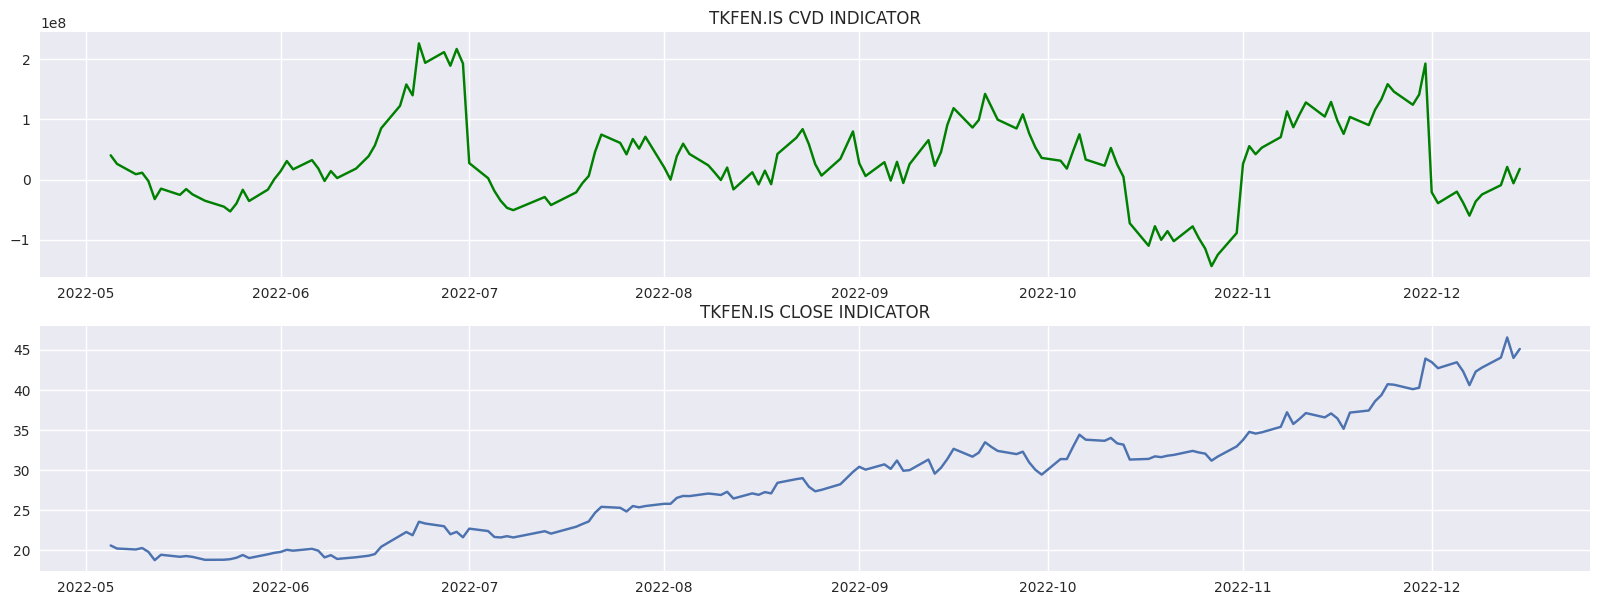

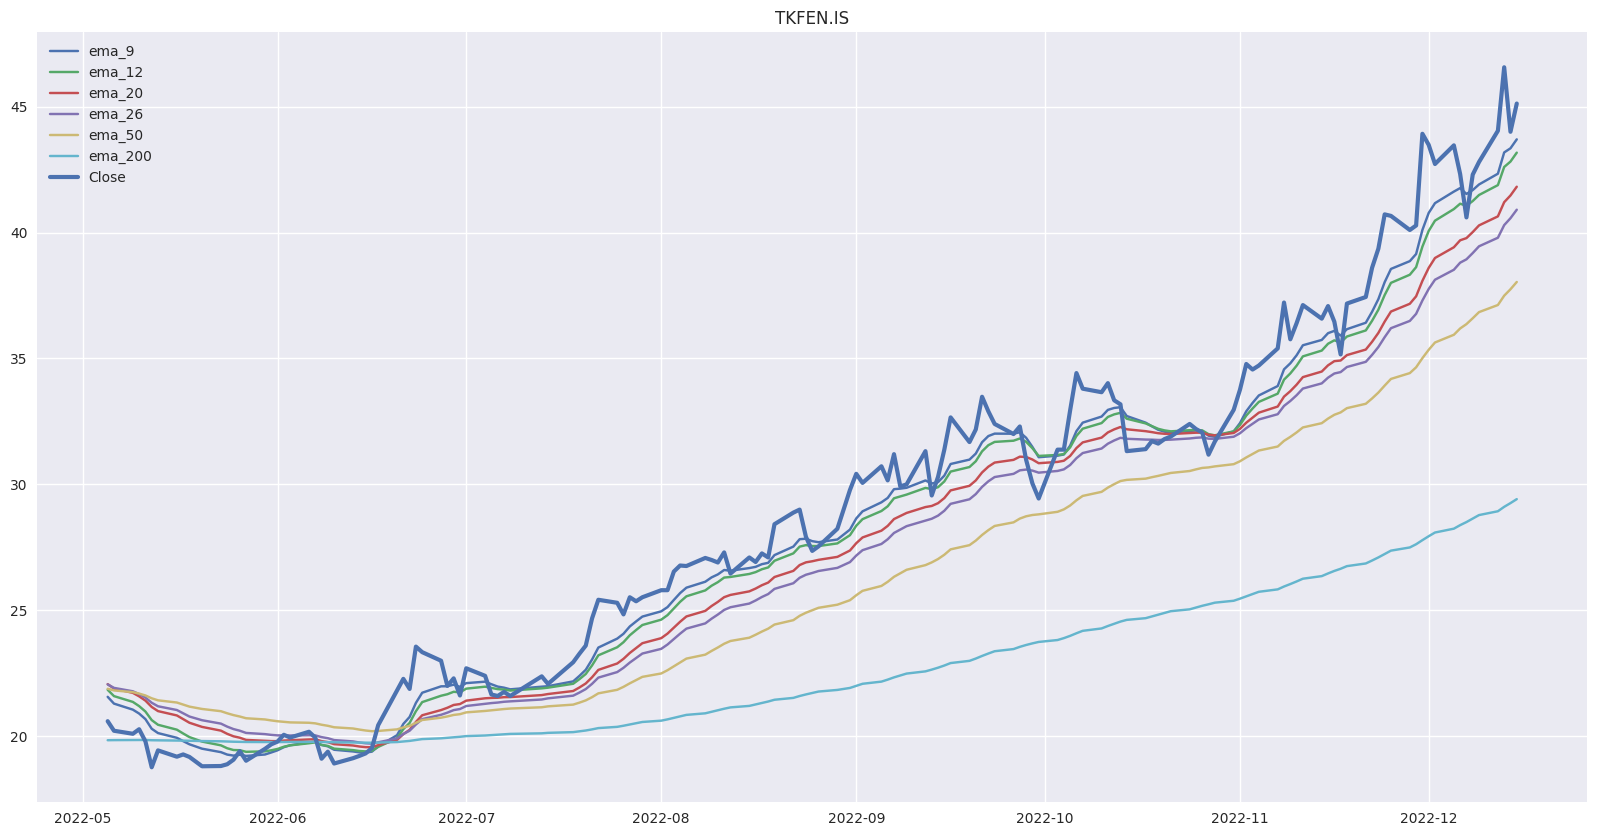

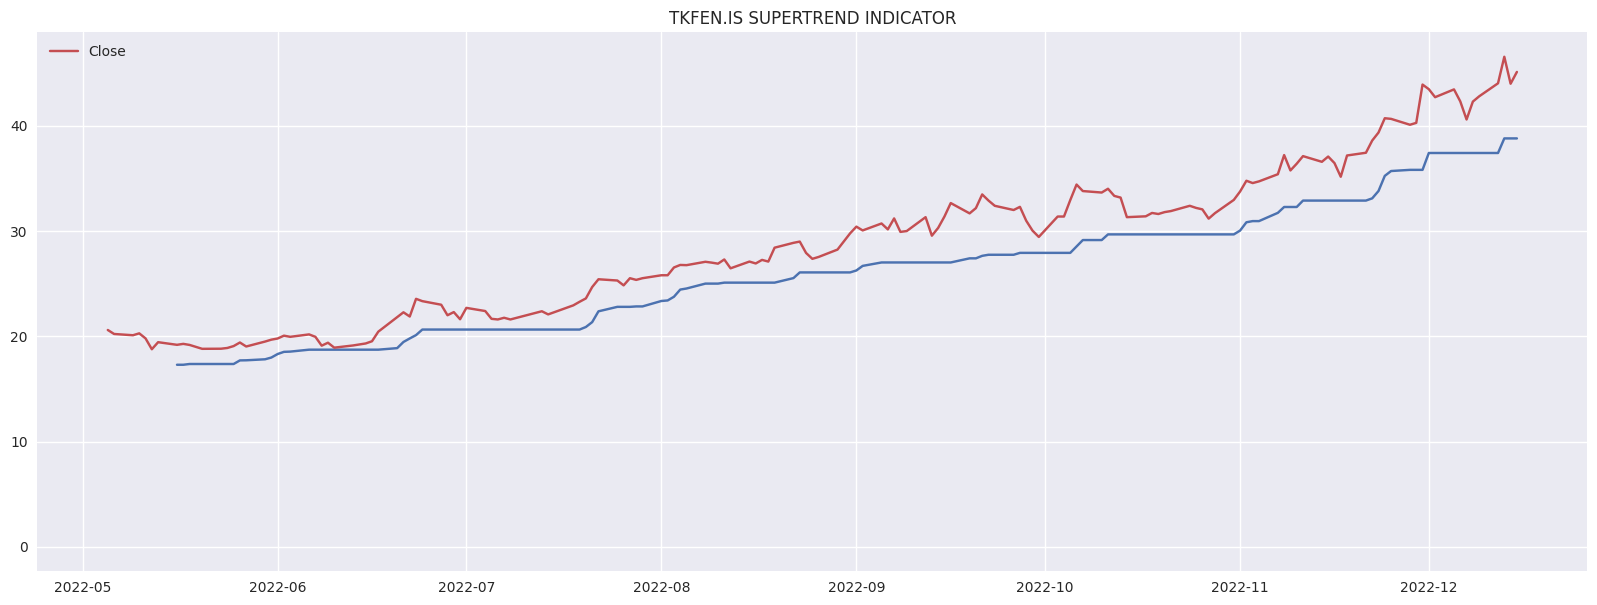

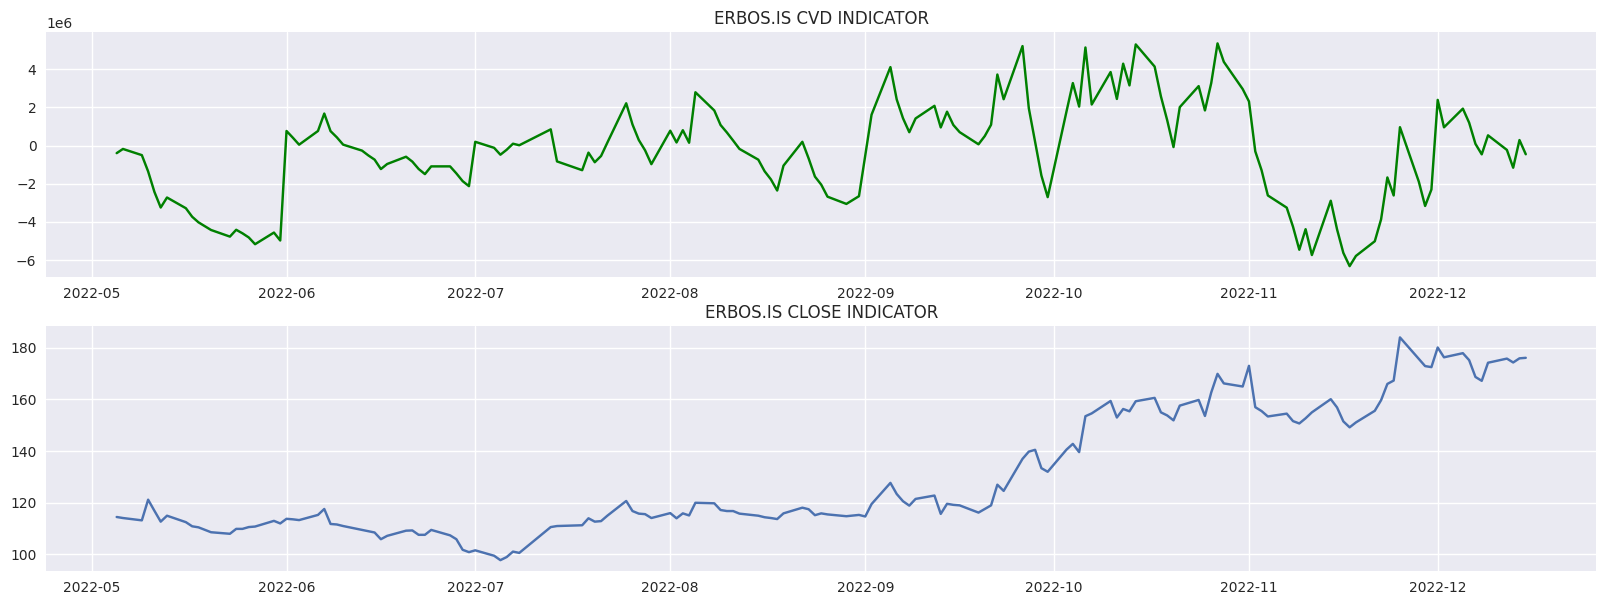

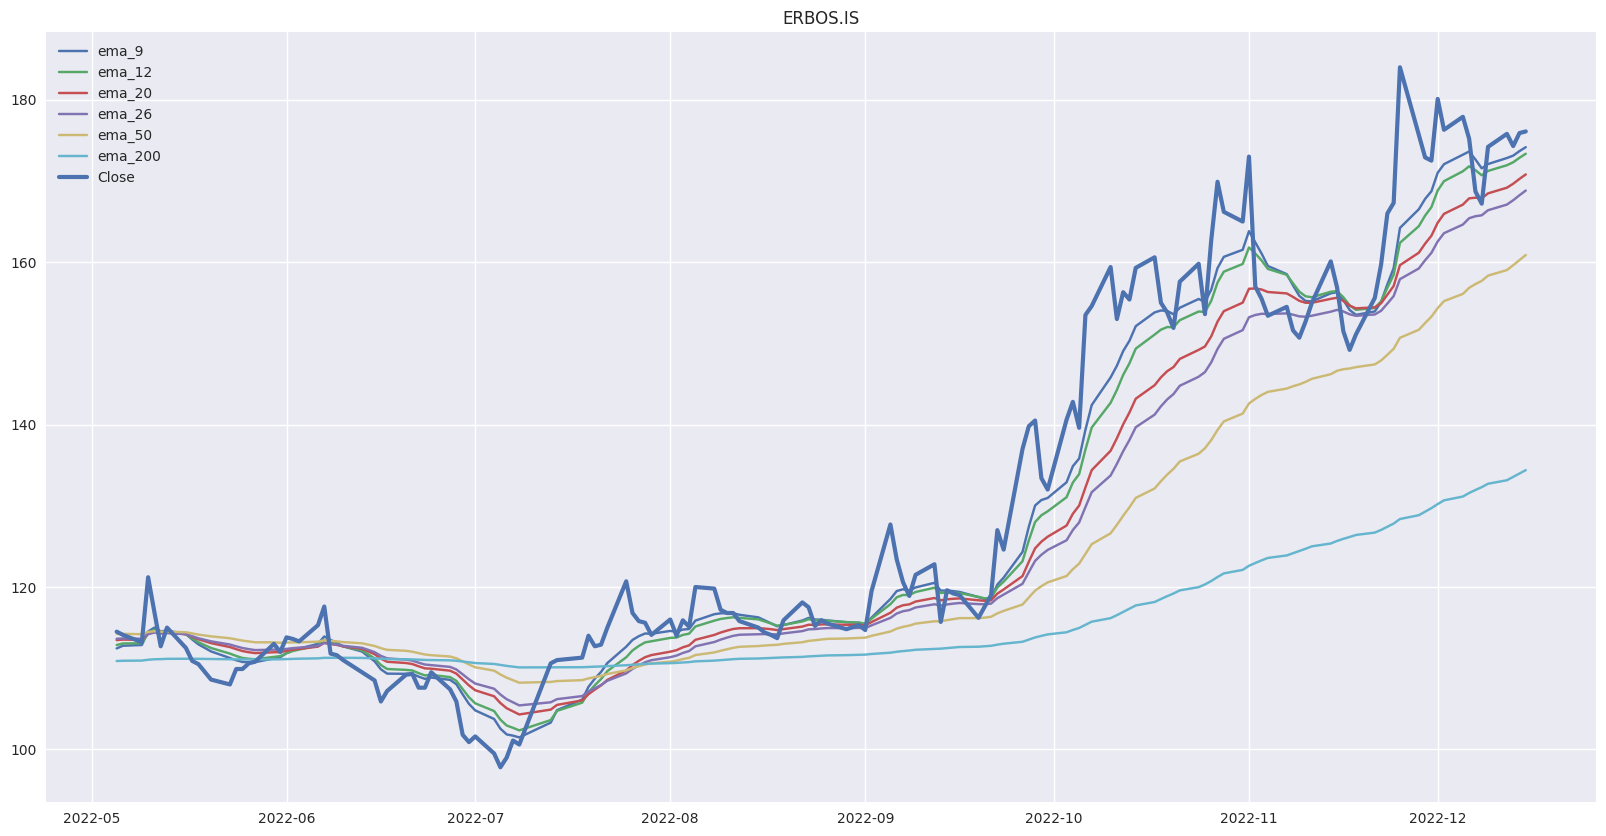

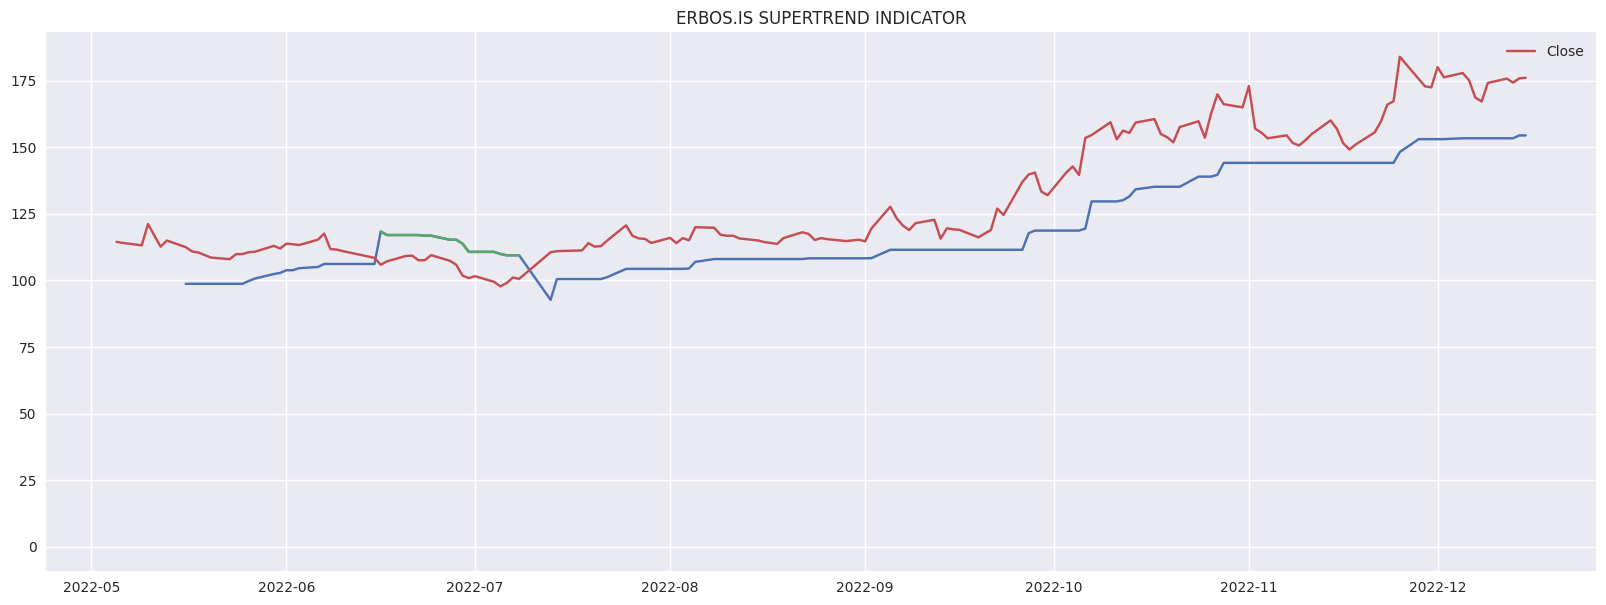

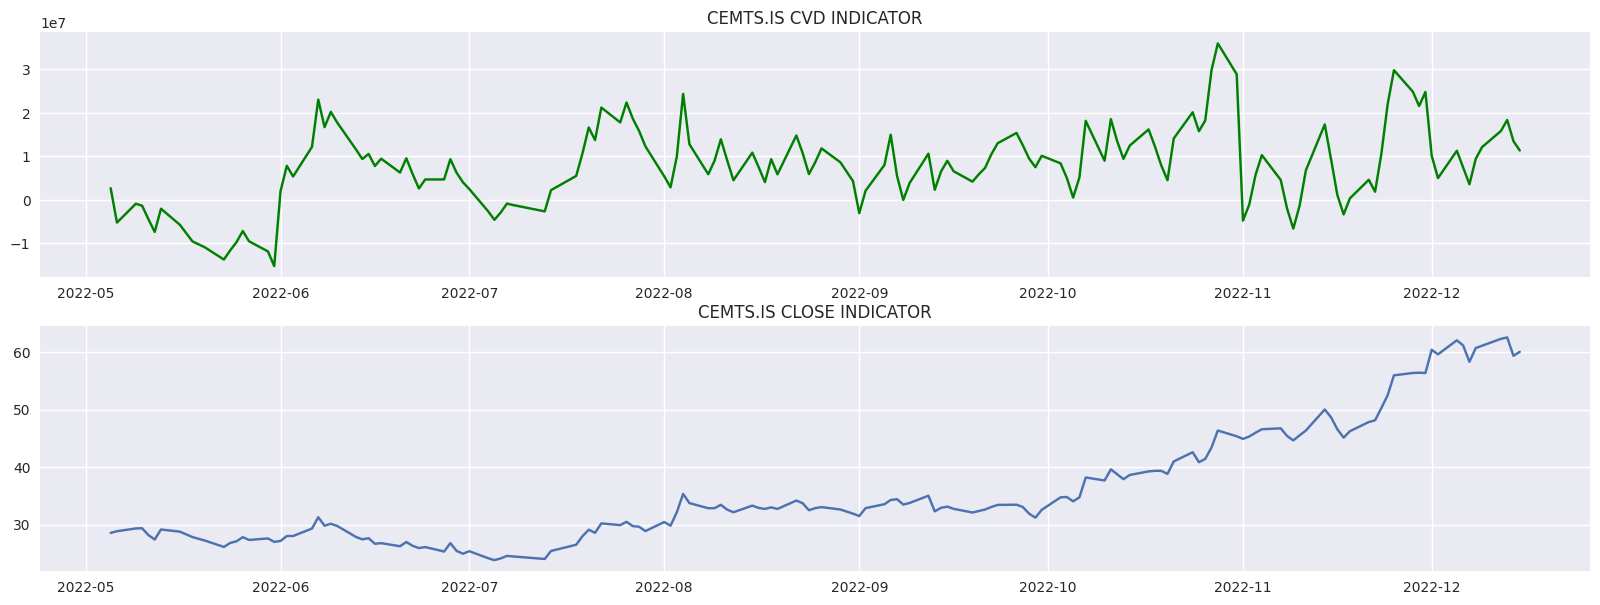

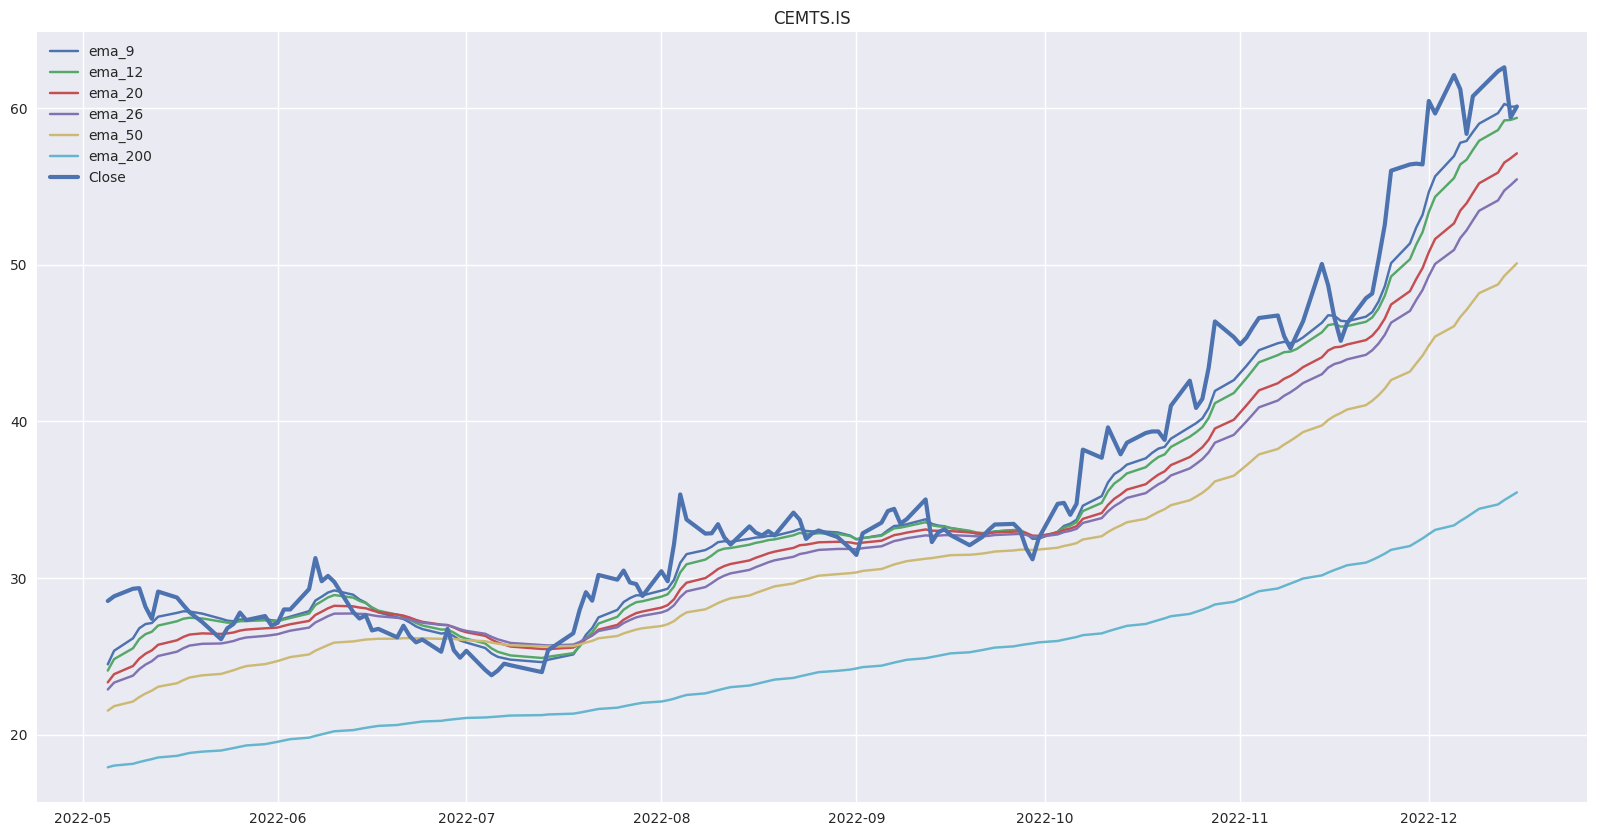

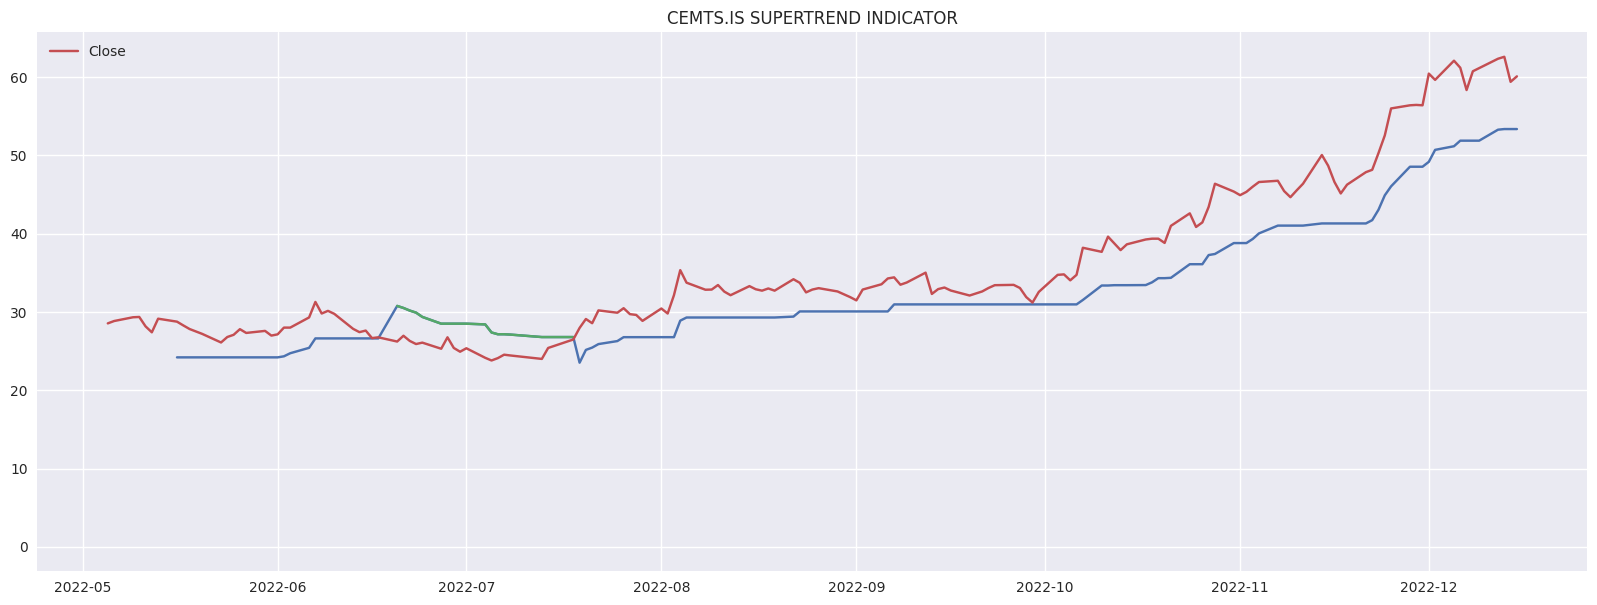

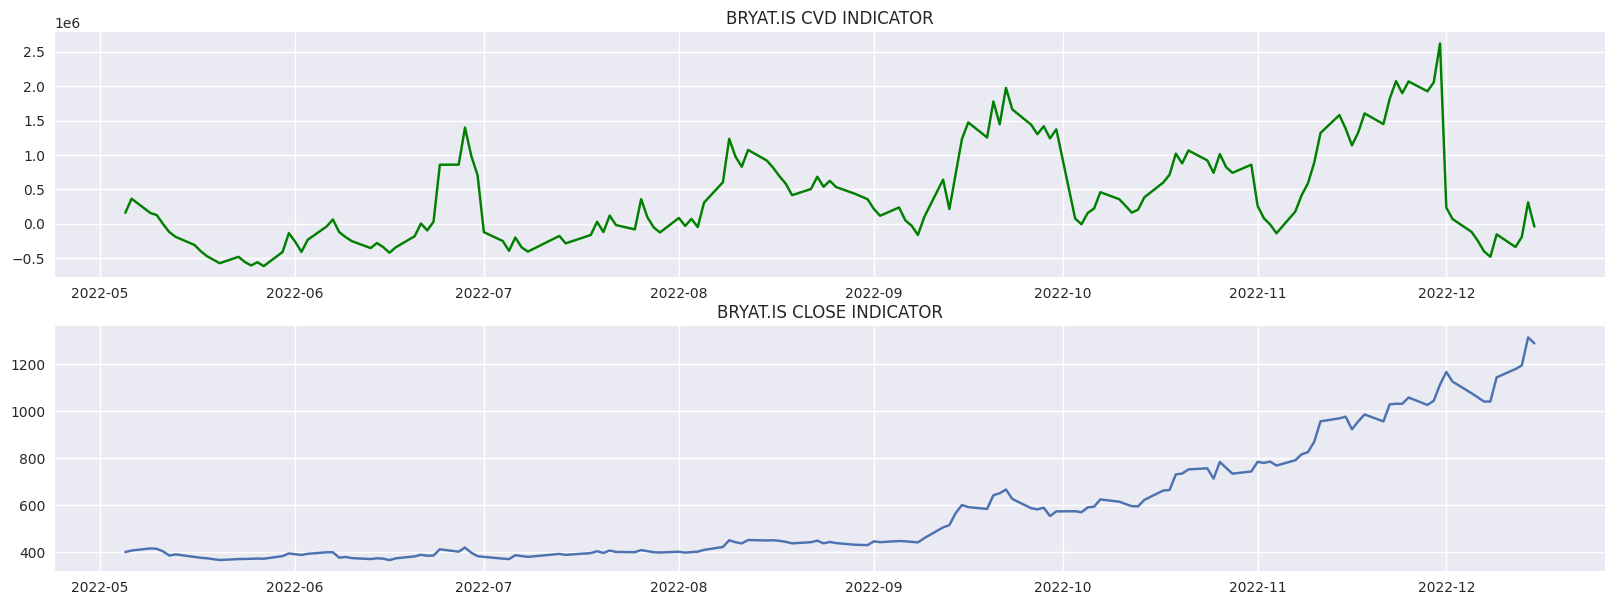

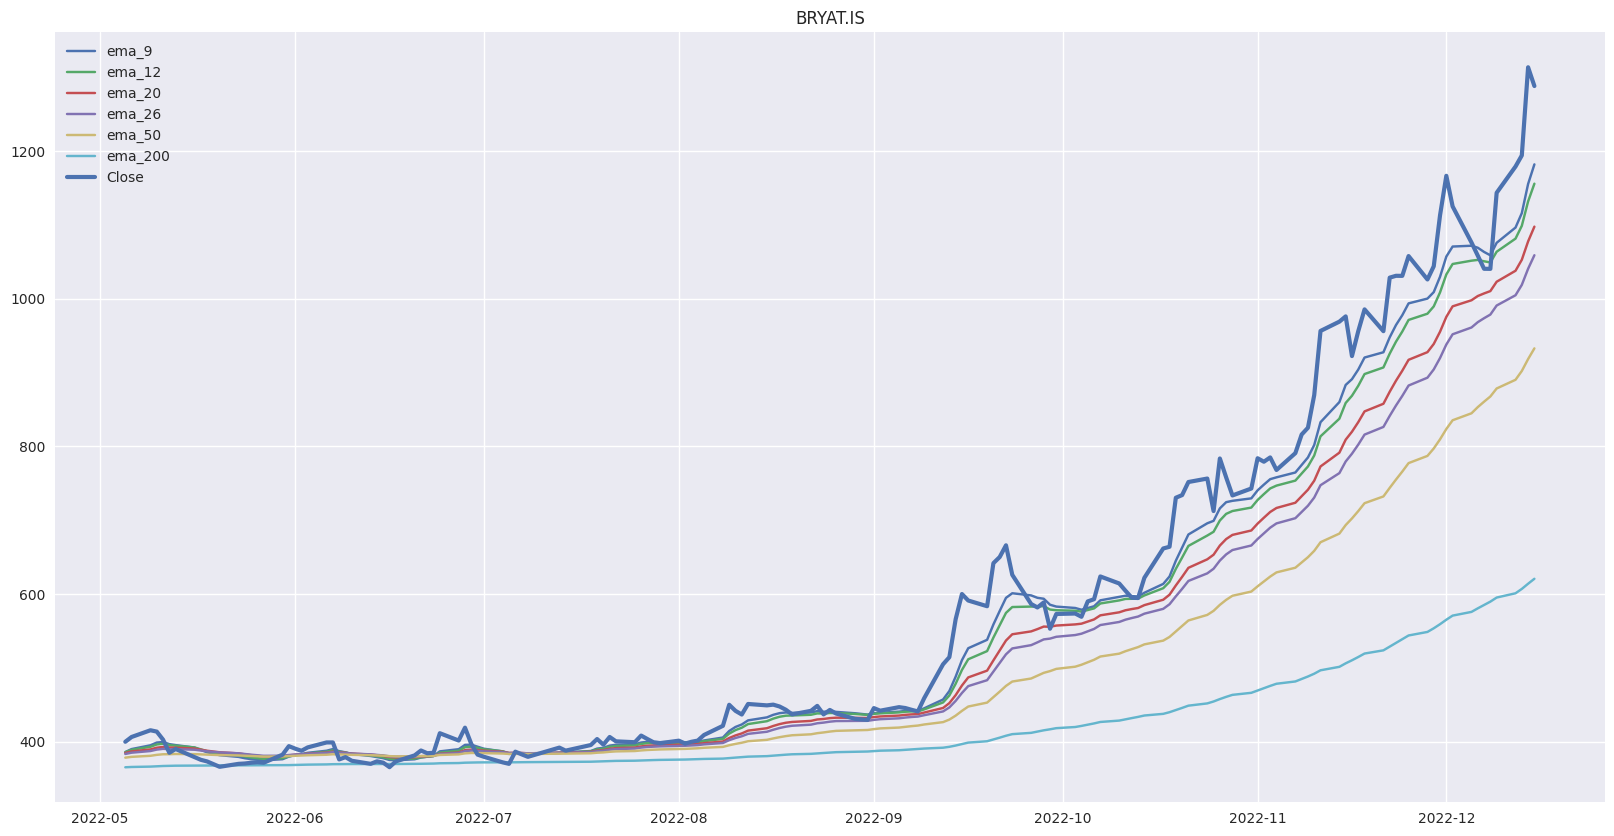

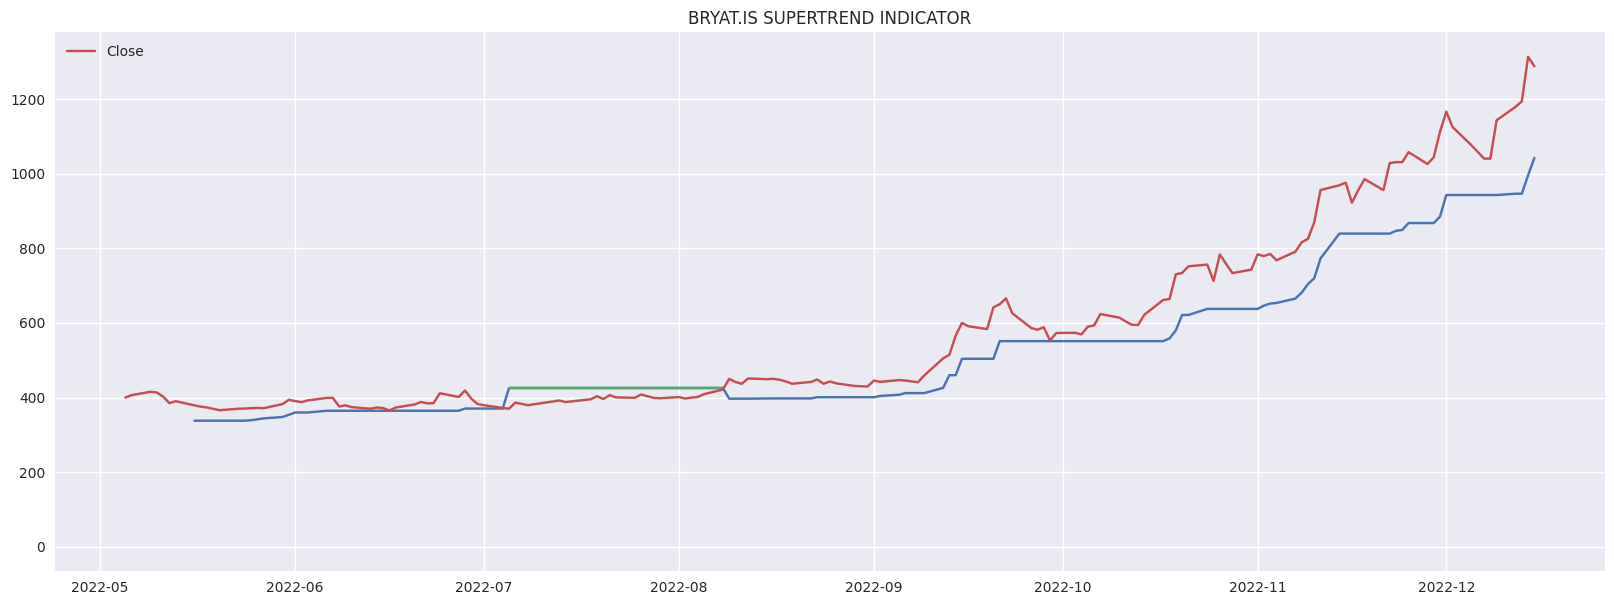

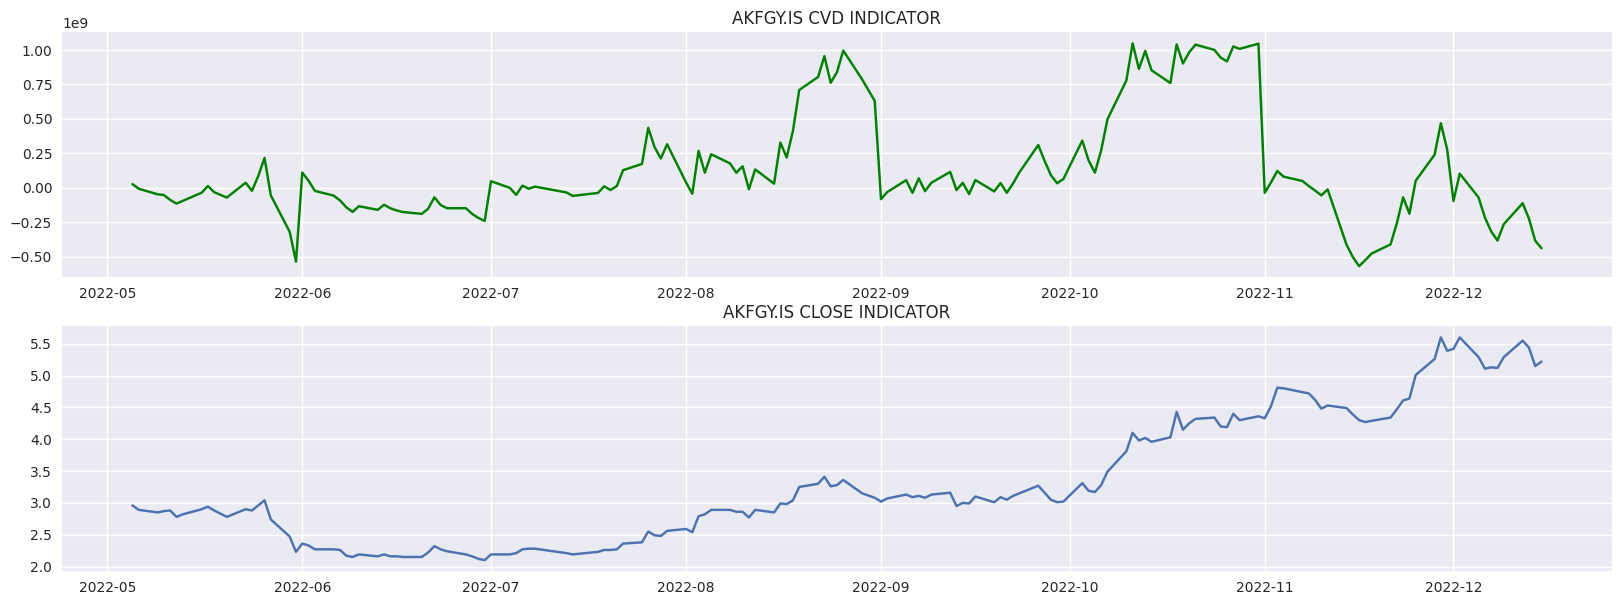

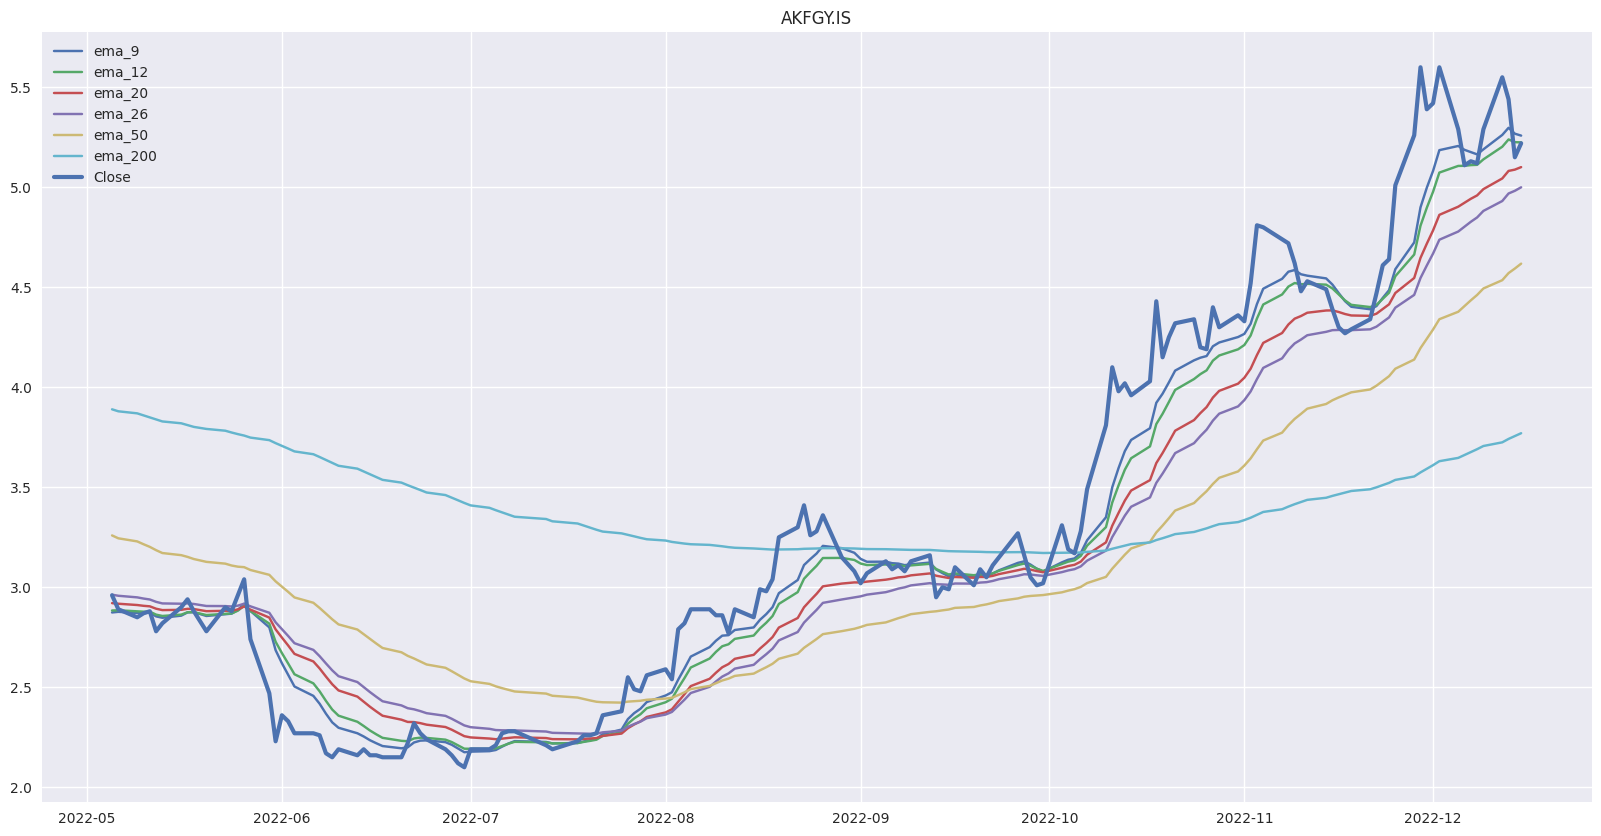

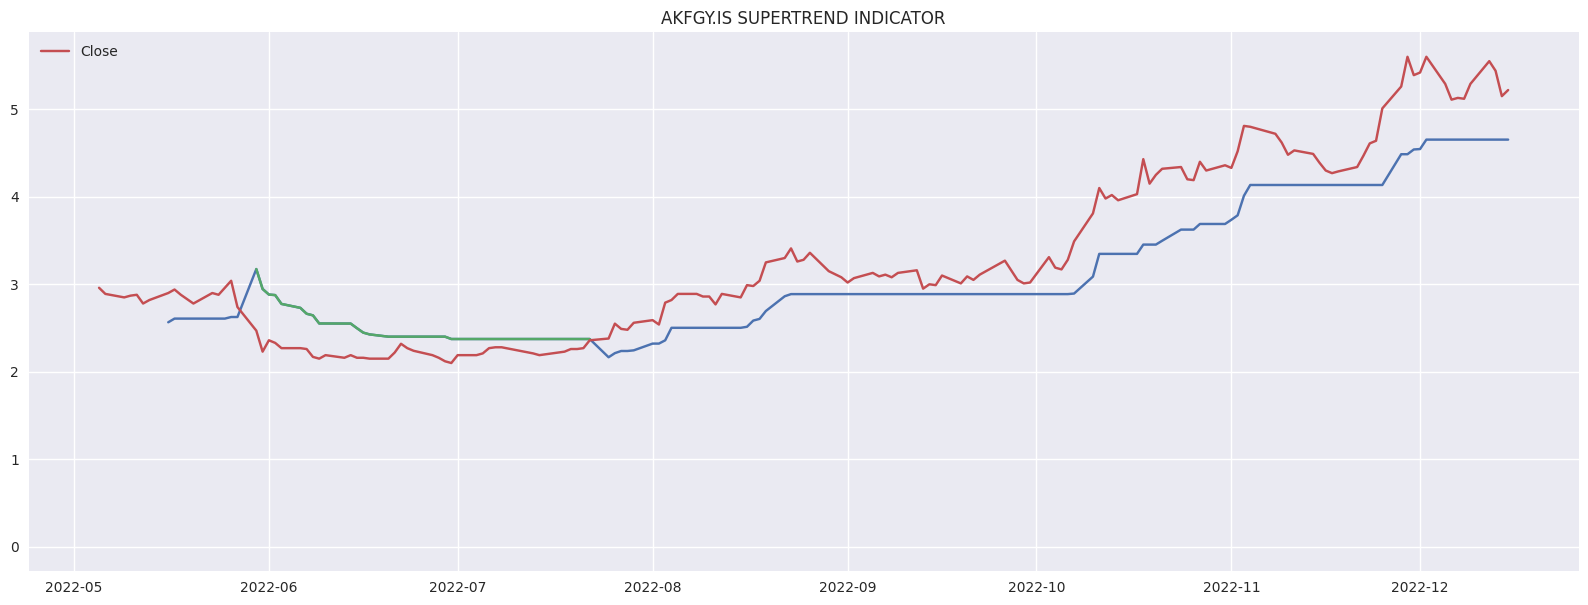

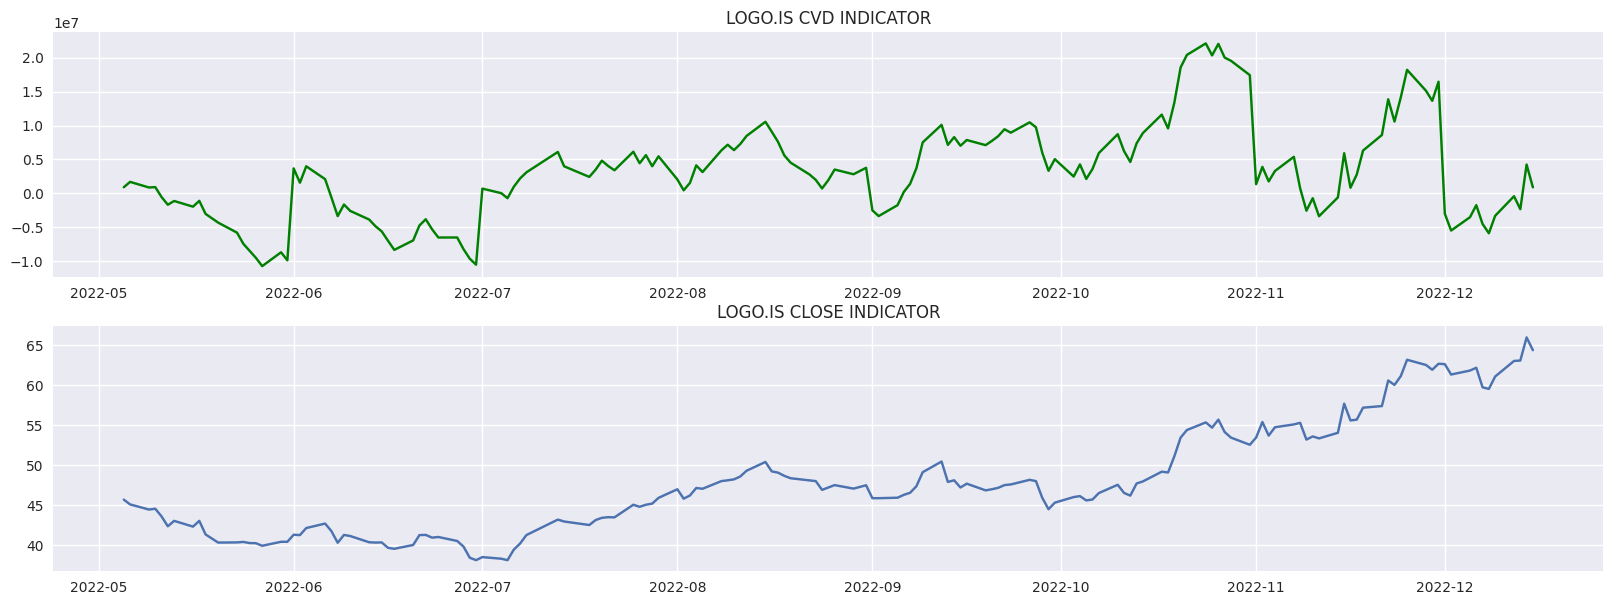

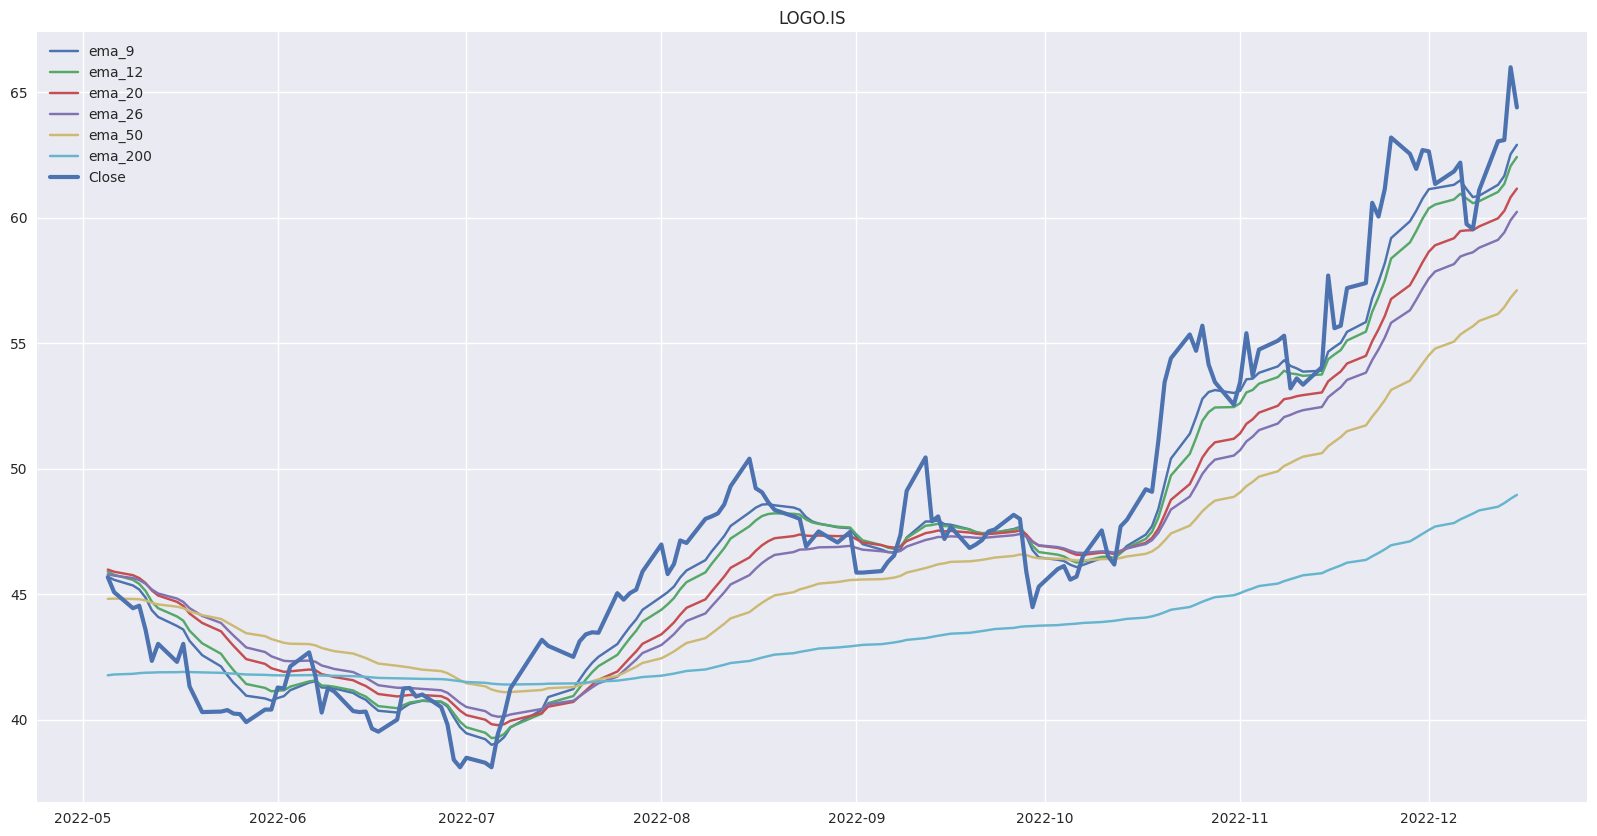

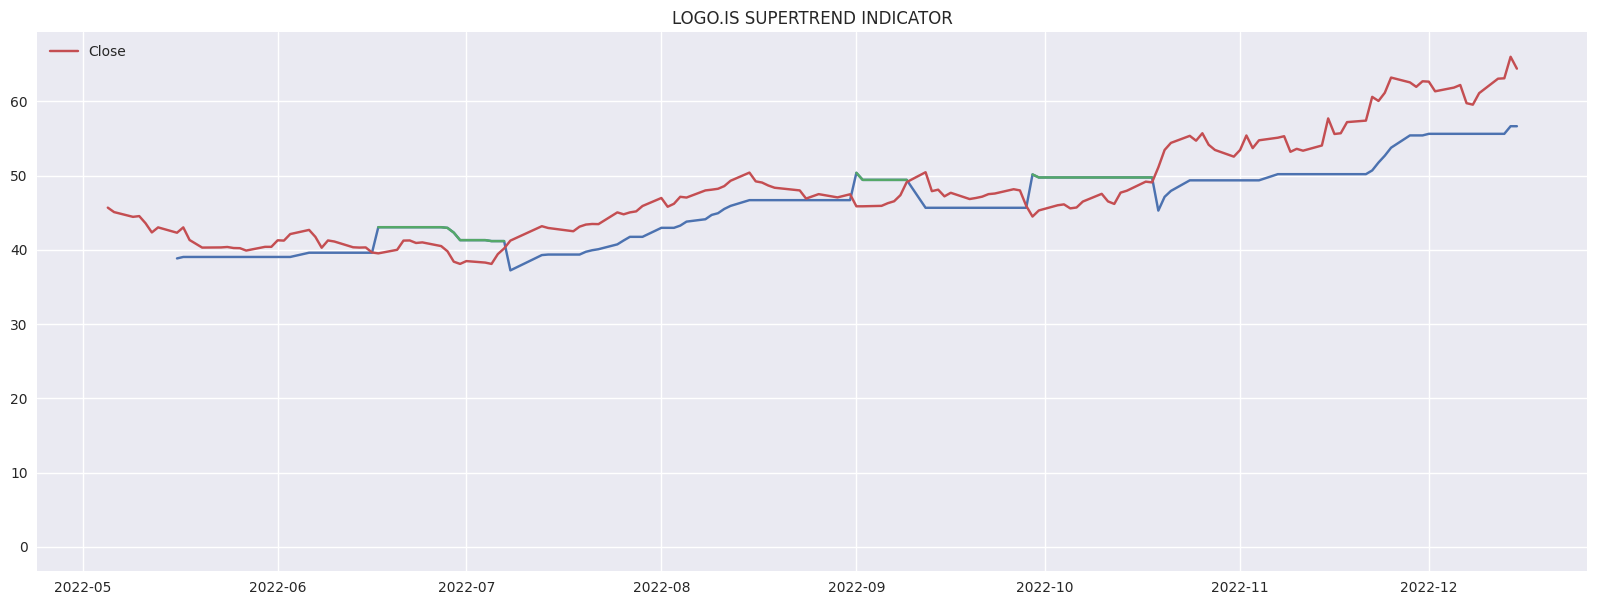

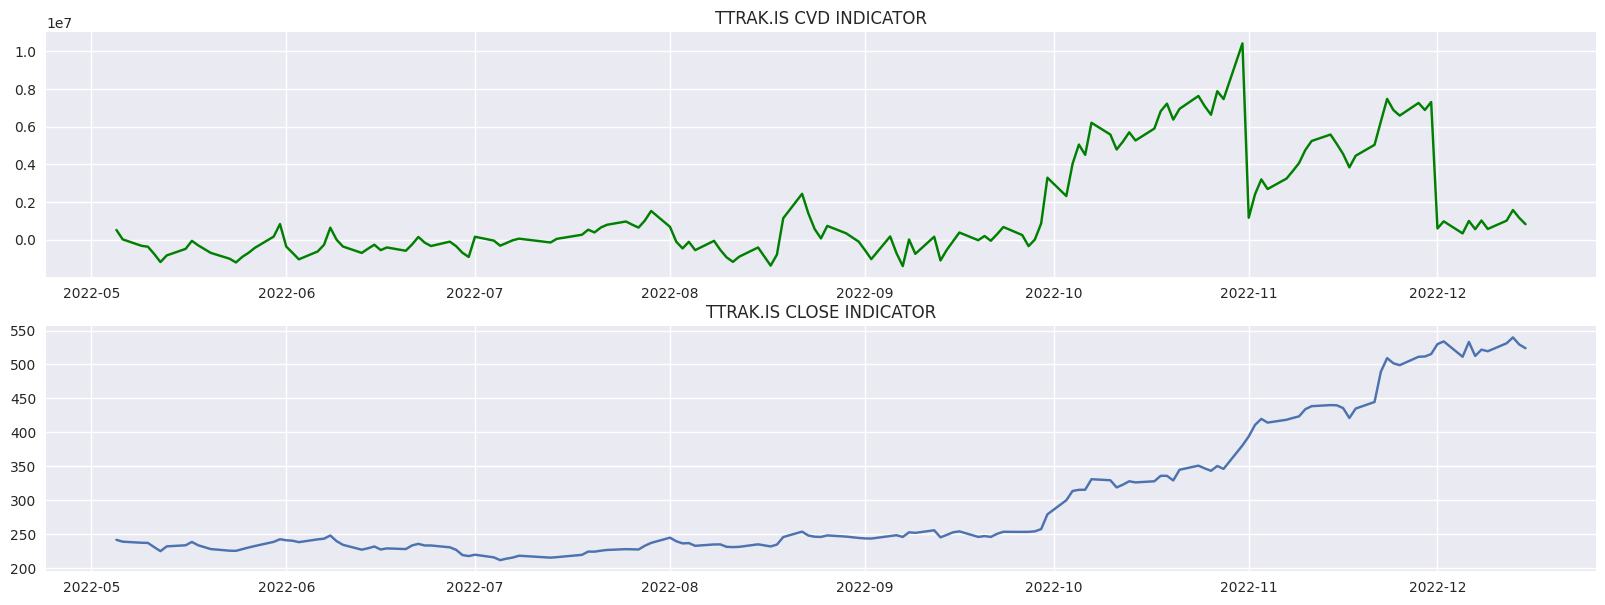

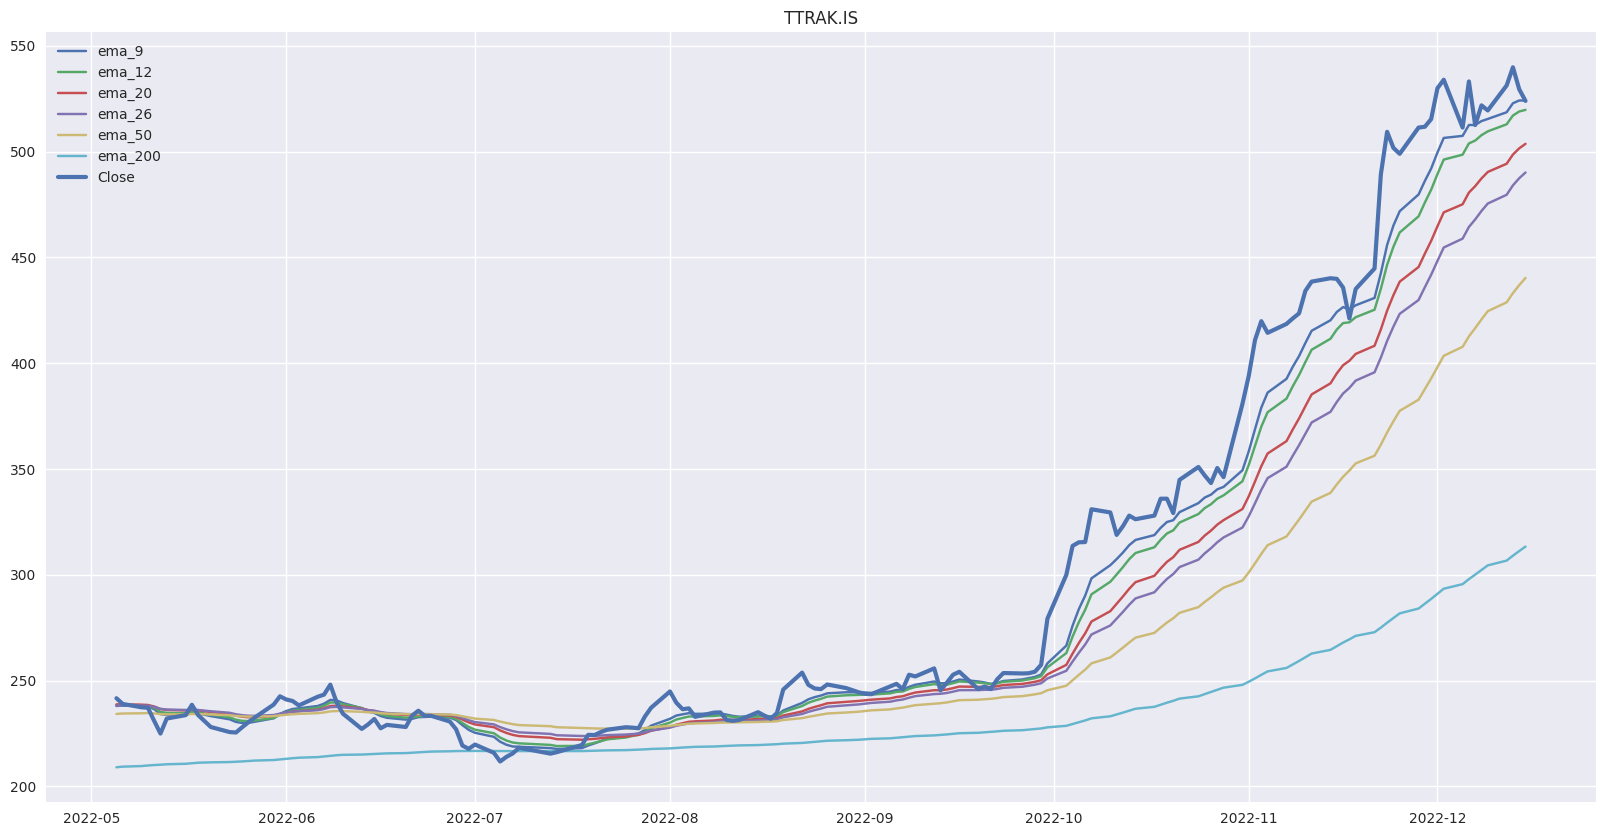

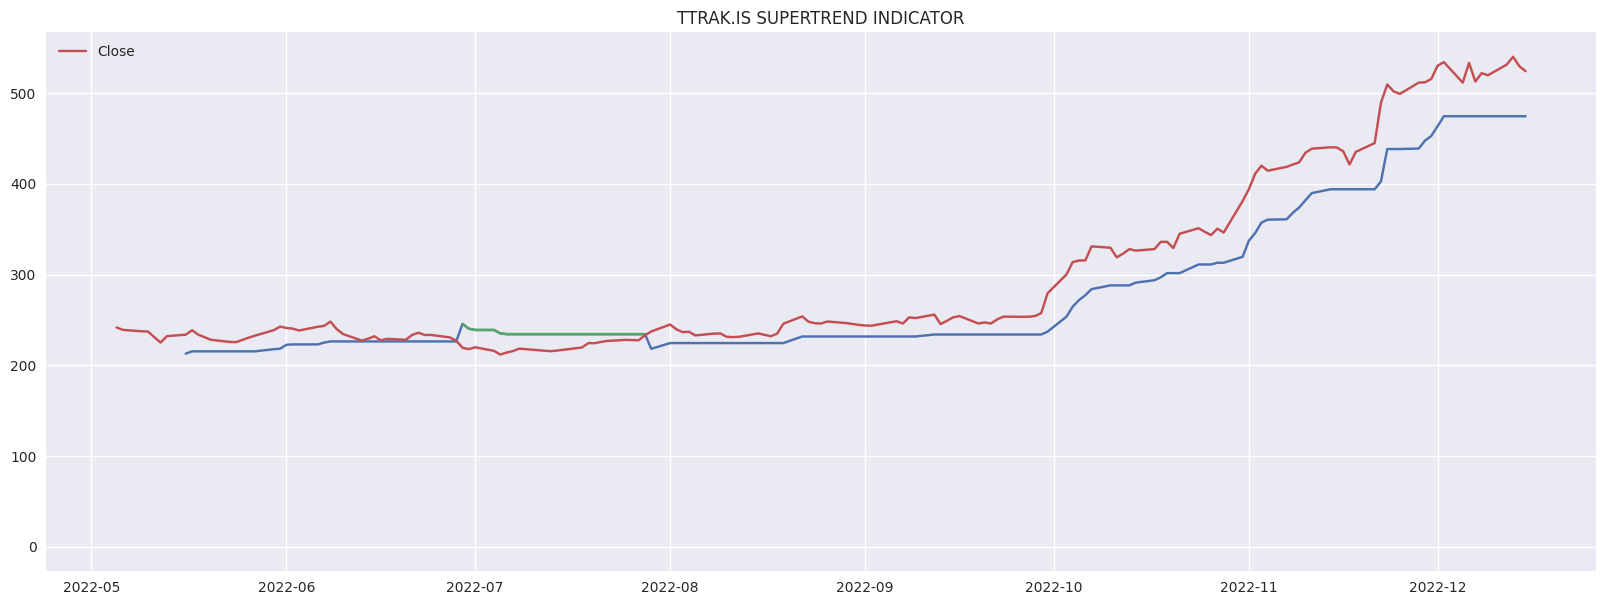

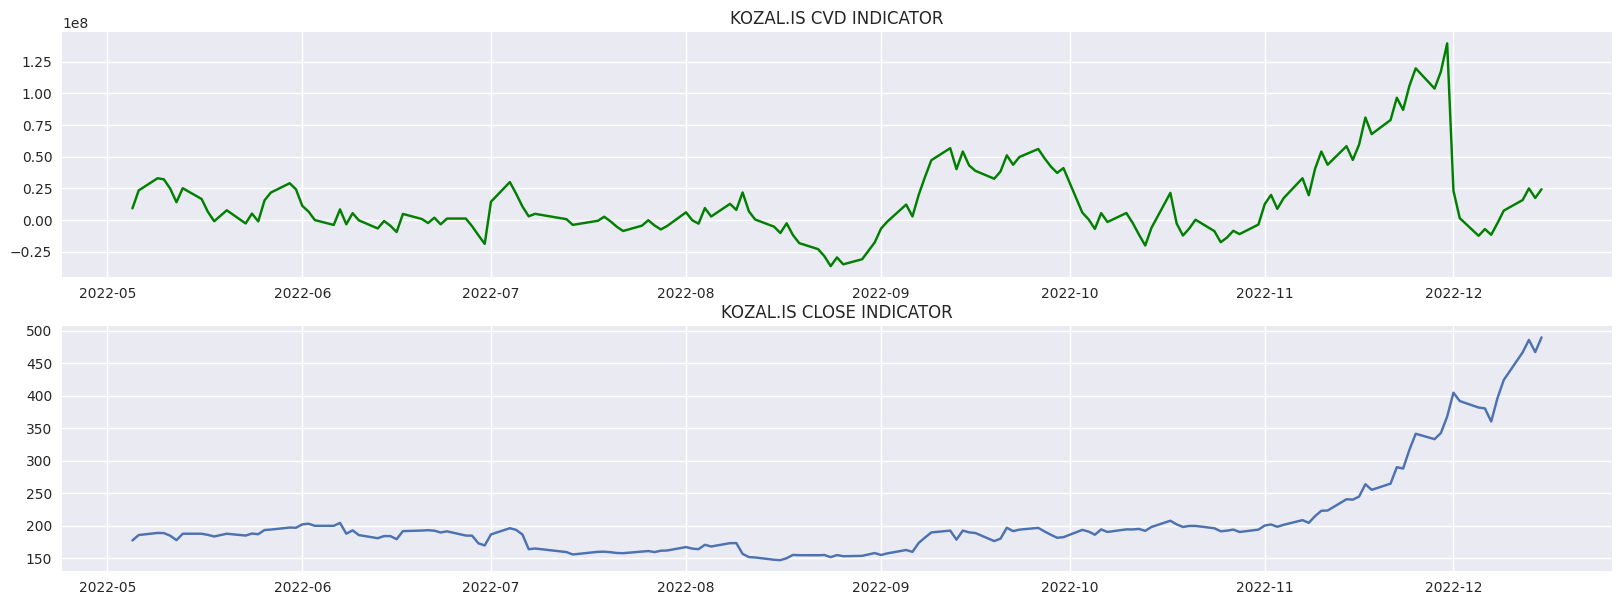

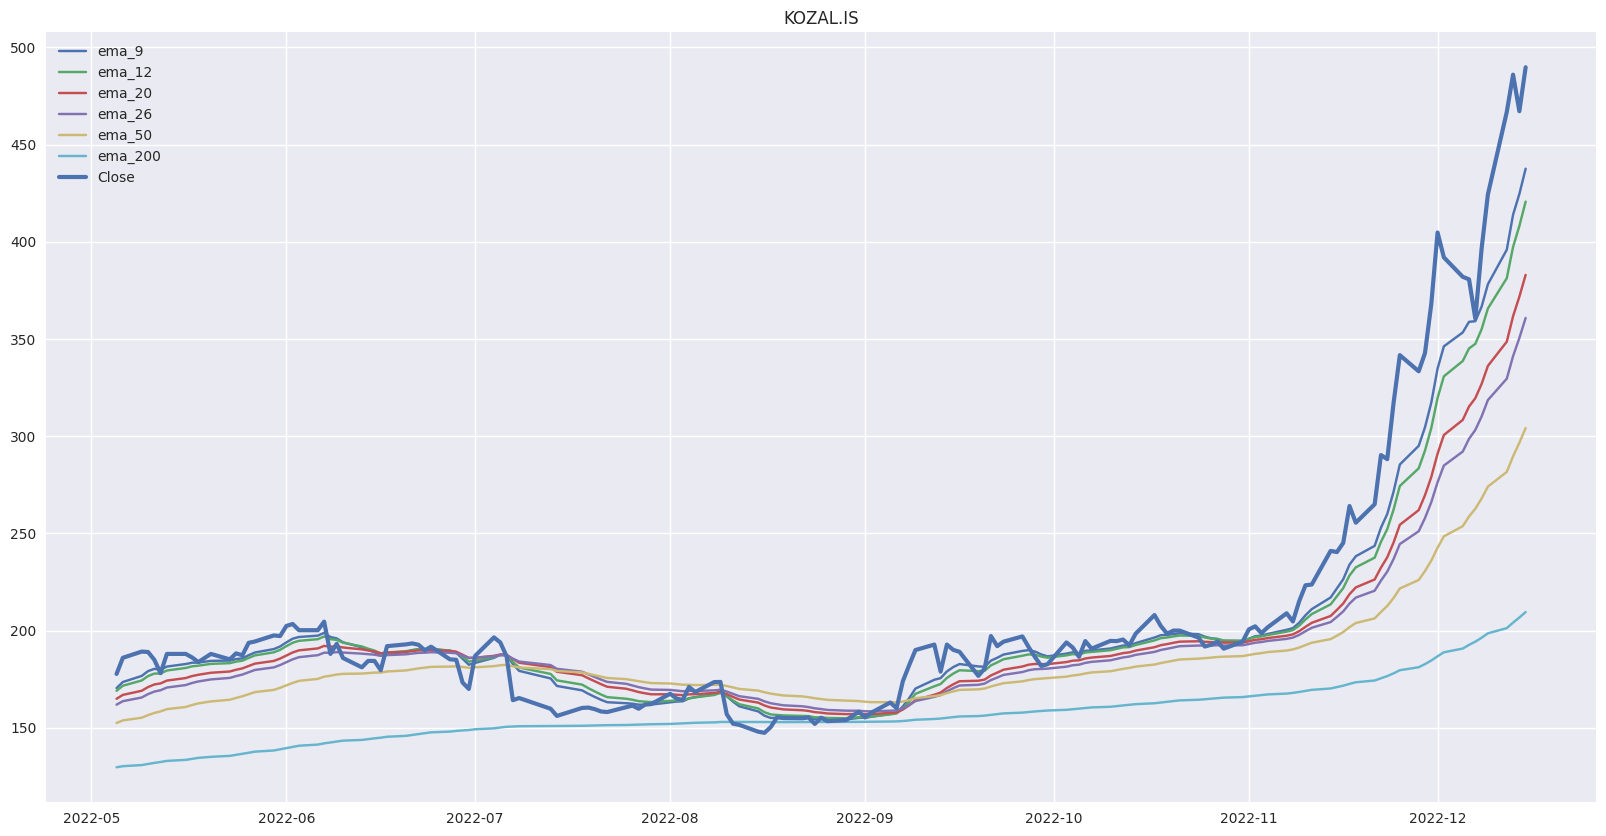

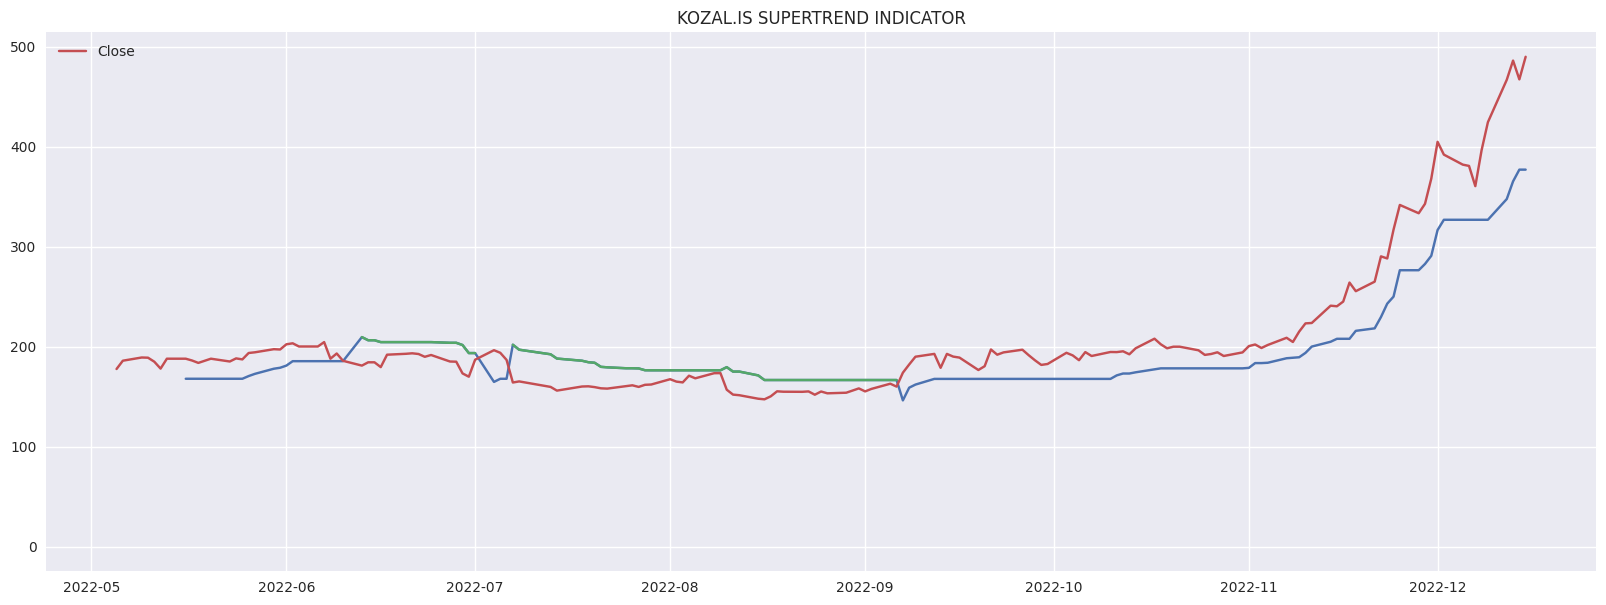

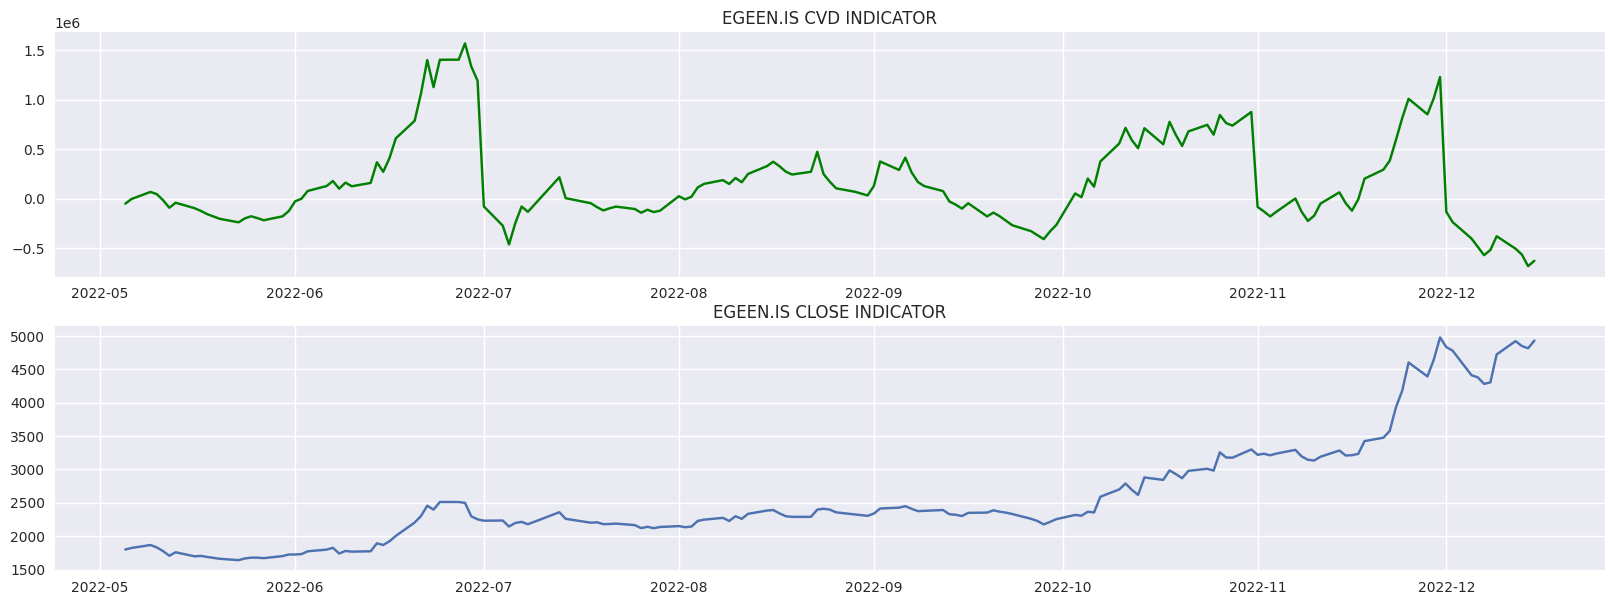

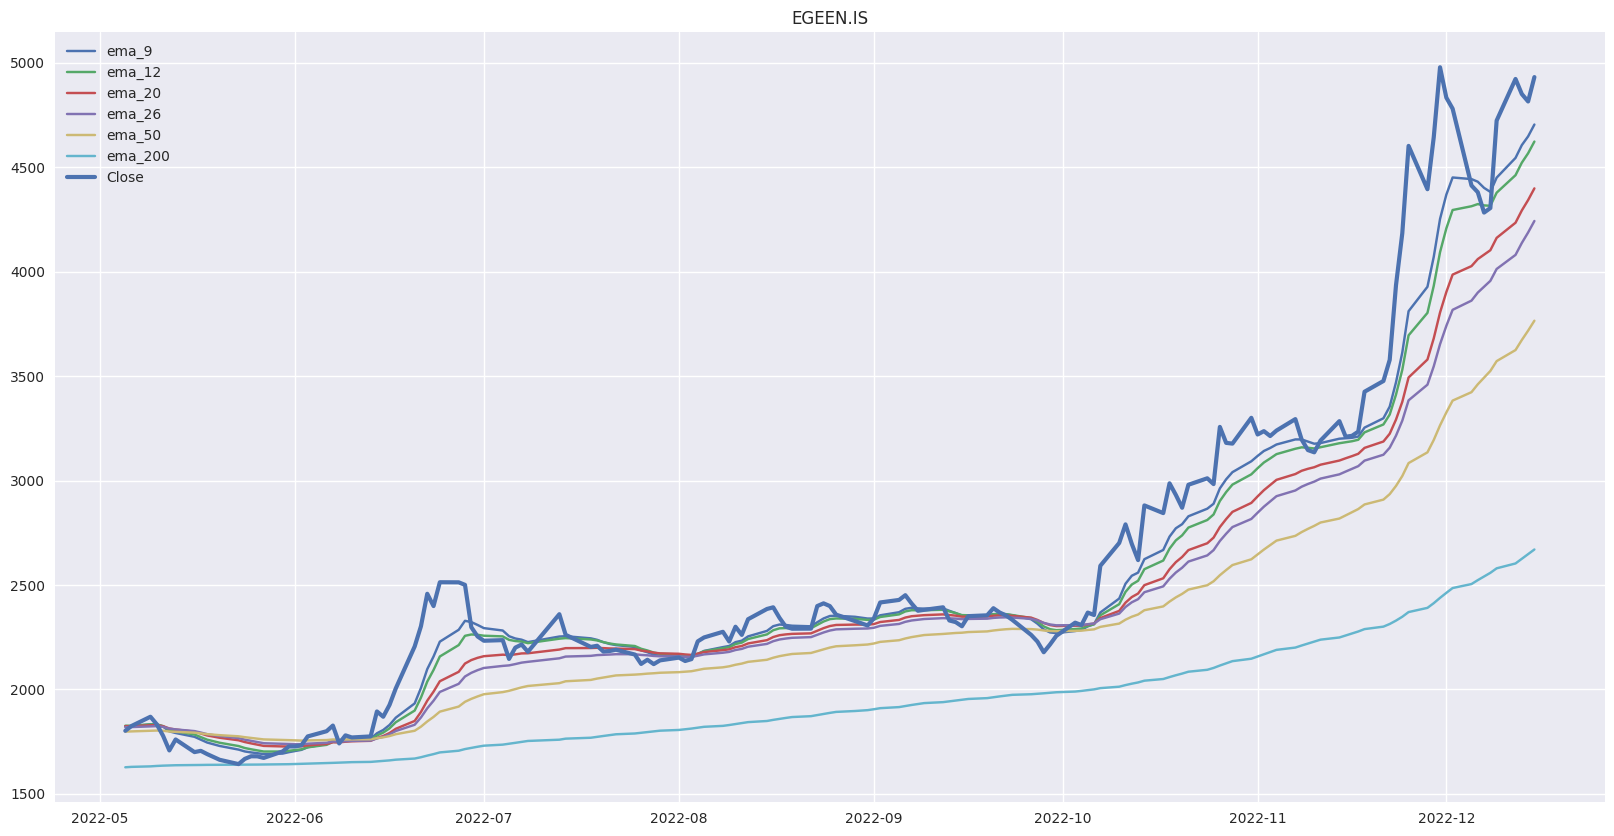

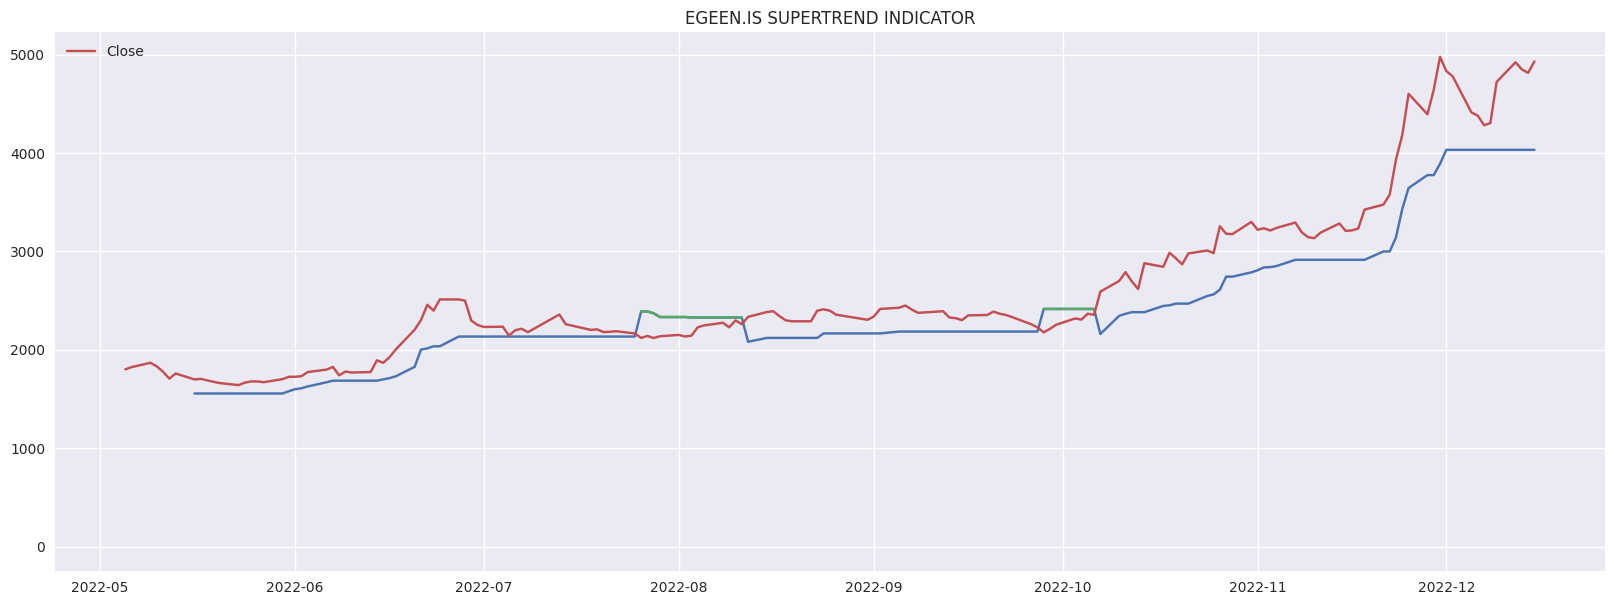

In [8]:
symbols = pd.read_csv('../data/symbol_data/bist100.csv', index_col=[0])

for i in range(1, 10):
    rnd = random.randint(1, len(symbols))
    SYMBOL = f"{symbols.loc[rnd, 'Code']}.IS"
    data = DataManipulation(SYMBOL, source, range_list, period=period, interval=interval, scale=scale, prefix_path='..', saved_to_csv=False)

    df = data.df.copy()
    fulldf = cvd(df)
    df_temp = fulldf.loc['2022-05':,:].copy()
    
    sti = ta.supertrend(df_temp['high'], df_temp['low'], df_temp['close'], length=7, multiplier=3)
    sti.drop(columns=['SUPERTd_7_3.0', 'SUPERTl_7_3.0'], inplace=True)

    # PLOT THE CUMULATIVE VOLUME DELTA
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(20,7))
    ax1.plot(df_temp.cvd, color='green')
    ax1.set_title(f'{SYMBOL} CVD INDICATOR')

    ax2.plot(df_temp.close)
    ax2.set_title(f'{SYMBOL} CLOSE INDICATOR')

    # PLOT THE EMA'S
    fig, ax1 = plt.subplots(1,1, figsize=(20,10))
    ax1.plot(df_temp.ema_9, label='ema_9')
    ax1.plot(df_temp.ema_12, label='ema_12')
    ax1.plot(df_temp.ema_20, label='ema_20')
    ax1.plot(df_temp.ema_26, label='ema_26')
    ax1.plot(df_temp.ema_50, label='ema_50')
    ax1.plot(df_temp.ema_200, label='ema_200')
    ax1.plot(df_temp.close, label='Close', linewidth=3)
    ax1.set_title(f'{SYMBOL}')
    ax1.legend()

    # PLOT THE SUPERTREND
    fig, ax = plt.subplots(figsize=(20,7))
    ax.plot(sti)
    ax.plot(df_temp.close, label='Close')
    ax.set_title(f'{SYMBOL} SUPERTREND INDICATOR')
    ax.legend()
plt.show()